In [33]:
#import libraries
from pathlib import Path
import pandas as pd
import numpy as np
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

In [34]:
#import bitcoin stock data
csvpath = Path("BTC_USD.csv", parse_dates = True, infer_datetime_format = True ,index_col="Date")
df_btc = pd.read_csv(csvpath) 
df_btc.set_index(pd.to_datetime(df_btc['Date'], infer_datetime_format=True), inplace = True)
df_btc['Date'] = pd.to_datetime(df_btc['Date'])
df_btc=df_btc.loc['02-01-2018':'08-14-2020']
df_btc.drop(columns=['Date'], inplace = True)
df_btc.head()

,BTC,BTC_VOL,SP_500
Date,,,
2018-02-01,9171.0,9.959400e+09,2822.0
2018-02-02,8831.0,1.272690e+10,2762.0
2018-02-03,9175.0,7.263790e+09,2649.0
2018-02-04,8277.0,7.073550e+09,2695.0
2018-02-05,6955.0,9.285290e+09,2682.0


In [35]:
#import fng data;  by date
csvpath = Path("fng.csv", parse_dates= True, infer_datetime_format = True) #, index_col="date")
df_fng = pd.read_csv(csvpath)
df_fng['Date'] = pd.to_datetime(df_fng['date'])
df_fng = df_fng.drop(columns=["fng_classification","date"])
df_fng=df_fng.set_index('Date')
df_fng.sort_index()
df_fng.tail()

,fng_value
Date,
2018-02-05,11
2018-02-04,24
2018-02-03,40
2018-02-02,15
2018-02-01,30


In [36]:
#combine dataframes
#combined = pd.concat([df_fng, df], axis = "columns" , join="inner")
#df_fng.merge(df)
combine=pd.merge(df_btc, df_fng, left_index=True, right_index=True)
combine.head()

,BTC,BTC_VOL,SP_500,fng_value
Date,,,,
2018-02-01,9171.0,9.959400e+09,2822.0,30
2018-02-02,8831.0,1.272690e+10,2762.0,15
2018-02-03,9175.0,7.263790e+09,2649.0,40
2018-02-04,8277.0,7.073550e+09,2695.0,24
2018-02-05,6955.0,9.285290e+09,2682.0,11


In [37]:
combine.tail()

,BTC,BTC_VOL,SP_500,fng_value
Date,,,,
2020-08-10,11878.0,2.611411e+10,11878.0,78
2020-08-11,11411.0,2.703978e+10,11411.0,84
2020-08-12,11585.0,2.506455e+10,11585.0,75
2020-08-13,11784.0,2.752220e+10,11784.0,75
2020-08-14,11769.0,2.423796e+10,11769.0,78


In [38]:
print(len(combine))

923


In [39]:
#check for missing values
combine.isnull().sum()



BTC          1
BTC_VOL      1
SP_500       1
fng_value    0
dtype: int64

In [40]:
#fill missing values with previous value
combine=combine.fillna(method='pad')

In [41]:
#function to fill arrays with data
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window -1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [42]:
###function to fill arrays with multiple row data
#def window_data(combined, window, target_col_number):
#    X = []
#    y = []
#    for i in range(len(combined) - window -1):
#        features = combined.iloc[i:(i + window), :]
#        target = combined.iloc[(i + window), target_col_number]
#        X.append(features)
#        y.append(target)
#    return np.array(X), np.array(y).reshape(-1, 1)

In [43]:
#predict closing prices used a window=5 for fng values 


window_size = 5
feature_column = 3 #x values
target_column = 3 #y values
X, y = window_data(combine, window_size, feature_column, target_column)
#X = combine.iloc[:,0:3].values
#y=combine["fng_value"].values
#print(X)
### note this did not work multiple errors depending on window size

In [45]:
#split data 70%/30% of data for training
split = int(.7*len(X))
X_train = X[: split -1]
X_test = X[split:]
y_train = y[: split -1]
y_test = y[split:]


In [46]:
#shape is (data, window size)
#y_train.shape
X_train.shape

(640, 5)

In [47]:
X_test.shape
#y_test.shape

(276, 5)

In [48]:
# Use MinMaxScaler to scale the data between 0 and 1.

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)


In [49]:
# Reshape the features for the model
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
print (f"X_train sample {X_train[:3]}")
print (f"X_test sample {X_test[:3]}")

X_train sample [[[0.27777778]
  [0.11111111]
  [0.38888889]
  [0.21111111]
  [0.06666667]]

 [[0.11111111]
  [0.38888889]
  [0.21111111]
  [0.06666667]
  [0.03333333]]

 [[0.38888889]
  [0.21111111]
  [0.06666667]
  [0.03333333]
  [0.34444444]]]
X_test sample [[[0.54444444]
  [0.41111111]
  [0.36666667]
  [0.37777778]
  [0.38888889]]

 [[0.41111111]
  [0.36666667]
  [0.37777778]
  [0.38888889]
  [0.37777778]]

 [[0.36666667]
  [0.37777778]
  [0.38888889]
  [0.37777778]
  [0.36666667]]]


In [50]:
#build and train LSTM RNN

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [51]:
## Build the LSTM model
model = Sequential()
number_units = 5
dropout_fraction = .2
#1
model.add(LSTM(units= number_units, 
               return_sequences=True, 
               input_shape=(X_train.shape[1], 1)))
model.add(Dropout(dropout_fraction))
#2
model.add(LSTM(units = number_units, return_sequences= True))
model.add(Dropout(dropout_fraction))
#3
model.add(LSTM(units= number_units))
model.add(Dropout(dropout_fraction))
#outer
model.add(Dense(1))

In [52]:
#compile
model.compile(optimizer="adam", loss="mean_squared_error")

In [53]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 5, 5)              140       
_________________________________________________________________
dropout_6 (Dropout)          (None, 5, 5)              0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 5, 5)              220       
_________________________________________________________________
dropout_7 (Dropout)          (None, 5, 5)              0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 5)                 220       
_________________________________________________________________
dropout_8 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [54]:
model.fit(X_train, y_train, epochs = 15, shuffle = False, batch_size=1, verbose = 1)

Epoch 1/15
640/640 [==============================] - 3s 5ms/step - loss: 0.0391
Epoch 2/15
640/640 [==============================] - 3s 5ms/step - loss: 0.0278
Epoch 3/15
640/640 [==============================] - 3s 5ms/step - loss: 0.0231
Epoch 4/15
640/640 [==============================] - 3s 5ms/step - loss: 0.0203
Epoch 5/15
640/640 [==============================] - 3s 5ms/step - loss: 0.0202
Epoch 6/15
640/640 [==============================] - 3s 5ms/step - loss: 0.0190
Epoch 7/15
640/640 [==============================] - 3s 5ms/step - loss: 0.0187
Epoch 8/15
640/640 [==============================] - 3s 5ms/step - loss: 0.0168
Epoch 9/15
640/640 [==============================] - 3s 5ms/step - loss: 0.0166
Epoch 10/15
640/640 [==============================] - 3s 5ms/step - loss: 0.0172
Epoch 11/15
640/640 [==============================] - 3s 5ms/step - loss: 0.0163
Epoch 12/15
640/640 [==============================] - 3s 5ms/step - loss: 0.0153
Epoch 13/15
640/640 [====

In [55]:
#model performance
model.evaluate(X_test, y_test)

9/9 [==============================] - 0s 2ms/step - loss: 0.0107


0.010659761726856232

In [56]:
predicted=model.predict(X_test)

In [57]:
#recover the original prices
predicted_numbers= scaler.inverse_transform(predicted)
real_numbers=scaler.inverse_transform(y_test.reshape(-1,1))


In [58]:
#create a DataFrame of real and predicted values
bt_fng =pd.DataFrame({"Real":real_numbers.ravel(), "Predicted":predicted_numbers.ravel()})
bt_fng.head()

,Real,Predicted
0,39.0,40.030796
1,38.0,40.308891
2,41.0,40.224335
3,38.0,40.388084
4,41.0,40.301380


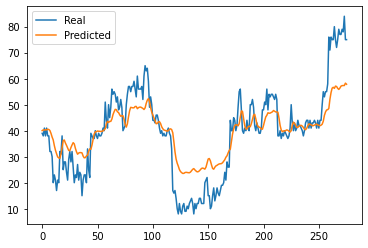

In [59]:
bt_fng.plot()